# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

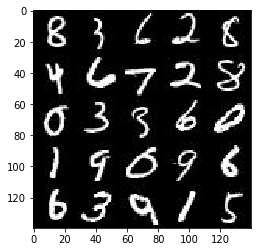

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

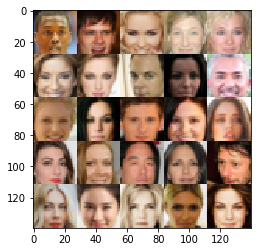

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/varsha/anaconda3/envs/project2_deep_learning/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_images = tf.placeholder(tf.float32, shape=(None, image_width,
                                                    image_height, image_channels))
    z_channel = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_images, z_channel, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [81]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * x1, x1)
     
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [82]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
     
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim ,4,  strides=2,  padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [83]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [84]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [85]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [86]:
class GAN:
    def __init__(self, z_size, real_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z, learning_rate_tensor = model_inputs(real_size[1],real_size[2], 
                                                     real_size[3], z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[3])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [100]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    net = GAN(z_dim, data_shape, learning_rate, alpha=0.2, beta1=beta1)
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25 ,net.input_z, data_shape[3], data_image_mode)

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10... Discriminator Loss: 0.0251... Generator Loss: 20.1458
Epoch 1/2... Step 20... Discriminator Loss: 0.1093... Generator Loss: 14.8079
Epoch 1/2... Step 30... Discriminator Loss: 0.0751... Generator Loss: 3.1200
Epoch 1/2... Step 40... Discriminator Loss: 0.4278... Generator Loss: 17.9499
Epoch 1/2... Step 50... Discriminator Loss: 0.0990... Generator Loss: 5.8475
Epoch 1/2... Step 60... Discriminator Loss: 0.0297... Generator Loss: 5.4899
Epoch 1/2... Step 70... Discriminator Loss: 0.3450... Generator Loss: 9.6141
Epoch 1/2... Step 80... Discriminator Loss: 0.4073... Generator Loss: 2.0526
Epoch 1/2... Step 90... Discriminator Loss: 0.1667... Generator Loss: 2.7037
Epoch 1/2... Step 100... Discriminator Loss: 0.1505... Generator Loss: 3.5148


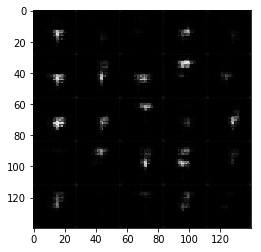

Epoch 1/2... Step 110... Discriminator Loss: 2.0135... Generator Loss: 0.2808
Epoch 1/2... Step 120... Discriminator Loss: 1.2472... Generator Loss: 3.4491
Epoch 1/2... Step 130... Discriminator Loss: 1.9972... Generator Loss: 0.3635
Epoch 1/2... Step 140... Discriminator Loss: 0.9417... Generator Loss: 1.0188
Epoch 1/2... Step 150... Discriminator Loss: 1.4305... Generator Loss: 0.4067
Epoch 1/2... Step 160... Discriminator Loss: 0.9769... Generator Loss: 0.9681
Epoch 1/2... Step 170... Discriminator Loss: 0.7963... Generator Loss: 1.3349
Epoch 1/2... Step 180... Discriminator Loss: 0.8923... Generator Loss: 0.9660
Epoch 1/2... Step 190... Discriminator Loss: 1.8664... Generator Loss: 0.3491
Epoch 1/2... Step 200... Discriminator Loss: 1.0955... Generator Loss: 0.8324


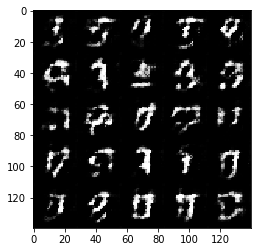

Epoch 1/2... Step 210... Discriminator Loss: 1.0657... Generator Loss: 1.7886
Epoch 1/2... Step 220... Discriminator Loss: 0.6370... Generator Loss: 1.8488
Epoch 1/2... Step 230... Discriminator Loss: 0.9580... Generator Loss: 1.1304
Epoch 1/2... Step 240... Discriminator Loss: 0.9356... Generator Loss: 3.2369
Epoch 1/2... Step 250... Discriminator Loss: 1.2883... Generator Loss: 0.6046
Epoch 1/2... Step 260... Discriminator Loss: 1.0792... Generator Loss: 0.5819
Epoch 1/2... Step 270... Discriminator Loss: 1.3801... Generator Loss: 0.6140
Epoch 1/2... Step 280... Discriminator Loss: 1.2342... Generator Loss: 0.6161
Epoch 1/2... Step 290... Discriminator Loss: 1.0273... Generator Loss: 1.7273
Epoch 1/2... Step 300... Discriminator Loss: 1.2361... Generator Loss: 0.5022


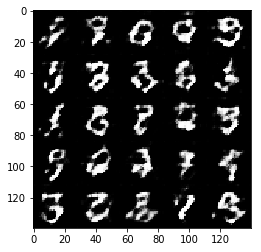

Epoch 1/2... Step 310... Discriminator Loss: 1.0833... Generator Loss: 0.7981
Epoch 1/2... Step 320... Discriminator Loss: 1.0139... Generator Loss: 1.1956
Epoch 1/2... Step 330... Discriminator Loss: 1.0940... Generator Loss: 1.6233
Epoch 1/2... Step 340... Discriminator Loss: 0.9974... Generator Loss: 0.8259
Epoch 1/2... Step 350... Discriminator Loss: 1.1073... Generator Loss: 0.6157
Epoch 1/2... Step 360... Discriminator Loss: 1.8745... Generator Loss: 0.2500
Epoch 1/2... Step 370... Discriminator Loss: 1.1229... Generator Loss: 0.9895
Epoch 1/2... Step 380... Discriminator Loss: 1.0457... Generator Loss: 0.9896
Epoch 1/2... Step 390... Discriminator Loss: 1.1299... Generator Loss: 0.6649
Epoch 1/2... Step 400... Discriminator Loss: 0.9949... Generator Loss: 0.9620


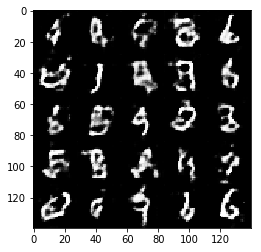

Epoch 1/2... Step 410... Discriminator Loss: 1.3445... Generator Loss: 0.4853
Epoch 1/2... Step 420... Discriminator Loss: 0.9906... Generator Loss: 0.7696
Epoch 1/2... Step 430... Discriminator Loss: 1.0136... Generator Loss: 0.6869
Epoch 1/2... Step 440... Discriminator Loss: 1.3737... Generator Loss: 0.4349
Epoch 1/2... Step 450... Discriminator Loss: 1.0297... Generator Loss: 0.8113
Epoch 1/2... Step 460... Discriminator Loss: 1.0814... Generator Loss: 0.7219
Epoch 1/2... Step 470... Discriminator Loss: 1.0698... Generator Loss: 1.0894
Epoch 1/2... Step 480... Discriminator Loss: 0.9258... Generator Loss: 0.8619
Epoch 1/2... Step 490... Discriminator Loss: 1.1103... Generator Loss: 0.6336
Epoch 1/2... Step 500... Discriminator Loss: 0.8920... Generator Loss: 1.0029


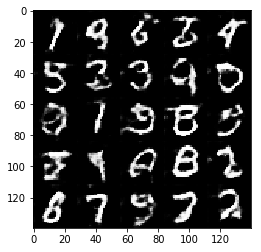

Epoch 1/2... Step 510... Discriminator Loss: 1.0521... Generator Loss: 0.9076
Epoch 1/2... Step 520... Discriminator Loss: 0.9603... Generator Loss: 0.7655
Epoch 1/2... Step 530... Discriminator Loss: 1.0413... Generator Loss: 1.4520
Epoch 1/2... Step 540... Discriminator Loss: 0.9609... Generator Loss: 0.9319
Epoch 1/2... Step 550... Discriminator Loss: 0.8706... Generator Loss: 1.1032
Epoch 1/2... Step 560... Discriminator Loss: 0.8844... Generator Loss: 0.9293
Epoch 1/2... Step 570... Discriminator Loss: 0.9741... Generator Loss: 1.1491
Epoch 1/2... Step 580... Discriminator Loss: 1.0795... Generator Loss: 0.7260
Epoch 1/2... Step 590... Discriminator Loss: 1.1435... Generator Loss: 0.5651
Epoch 1/2... Step 600... Discriminator Loss: 0.9673... Generator Loss: 1.0779


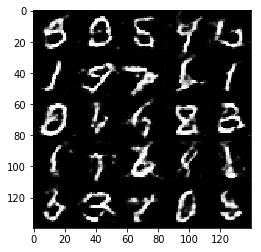

Epoch 1/2... Step 610... Discriminator Loss: 1.3959... Generator Loss: 0.4122
Epoch 1/2... Step 620... Discriminator Loss: 1.0930... Generator Loss: 0.5871
Epoch 1/2... Step 630... Discriminator Loss: 1.2909... Generator Loss: 0.4994
Epoch 1/2... Step 640... Discriminator Loss: 1.5207... Generator Loss: 0.3423
Epoch 1/2... Step 650... Discriminator Loss: 0.9510... Generator Loss: 0.7480
Epoch 1/2... Step 660... Discriminator Loss: 1.2104... Generator Loss: 0.4986
Epoch 1/2... Step 670... Discriminator Loss: 1.0531... Generator Loss: 0.9911
Epoch 1/2... Step 680... Discriminator Loss: 0.9957... Generator Loss: 0.9245
Epoch 1/2... Step 690... Discriminator Loss: 1.2533... Generator Loss: 0.4844
Epoch 1/2... Step 700... Discriminator Loss: 1.1776... Generator Loss: 0.7851


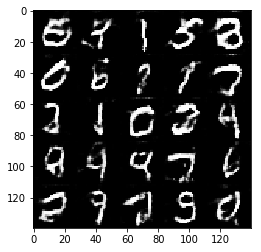

Epoch 1/2... Step 710... Discriminator Loss: 0.8561... Generator Loss: 1.5908
Epoch 1/2... Step 720... Discriminator Loss: 1.4367... Generator Loss: 0.3603
Epoch 1/2... Step 730... Discriminator Loss: 1.1651... Generator Loss: 0.5120
Epoch 1/2... Step 740... Discriminator Loss: 1.8392... Generator Loss: 0.2449
Epoch 1/2... Step 750... Discriminator Loss: 0.9469... Generator Loss: 0.9328
Epoch 1/2... Step 760... Discriminator Loss: 1.0381... Generator Loss: 0.6115
Epoch 1/2... Step 770... Discriminator Loss: 2.2407... Generator Loss: 3.1907
Epoch 1/2... Step 780... Discriminator Loss: 0.7334... Generator Loss: 1.4597
Epoch 1/2... Step 790... Discriminator Loss: 0.9742... Generator Loss: 1.6685
Epoch 1/2... Step 800... Discriminator Loss: 0.9459... Generator Loss: 0.7662


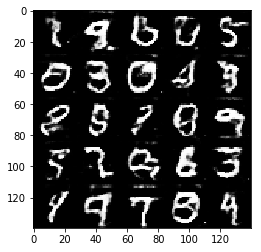

Epoch 1/2... Step 810... Discriminator Loss: 0.9475... Generator Loss: 0.8272
Epoch 1/2... Step 820... Discriminator Loss: 0.9746... Generator Loss: 0.9448
Epoch 1/2... Step 830... Discriminator Loss: 0.9788... Generator Loss: 0.6995
Epoch 1/2... Step 840... Discriminator Loss: 0.9280... Generator Loss: 0.6419
Epoch 1/2... Step 850... Discriminator Loss: 1.0191... Generator Loss: 2.2030
Epoch 1/2... Step 860... Discriminator Loss: 0.8885... Generator Loss: 1.2332
Epoch 1/2... Step 870... Discriminator Loss: 0.8176... Generator Loss: 1.0101
Epoch 1/2... Step 880... Discriminator Loss: 0.8653... Generator Loss: 1.1315
Epoch 1/2... Step 890... Discriminator Loss: 1.0458... Generator Loss: 0.6166
Epoch 1/2... Step 900... Discriminator Loss: 0.8882... Generator Loss: 1.1522


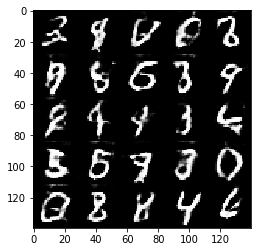

Epoch 1/2... Step 910... Discriminator Loss: 1.1557... Generator Loss: 0.5782
Epoch 1/2... Step 920... Discriminator Loss: 1.0347... Generator Loss: 0.7008
Epoch 1/2... Step 930... Discriminator Loss: 1.0516... Generator Loss: 1.8824
Epoch 2/2... Step 940... Discriminator Loss: 0.9570... Generator Loss: 0.9385
Epoch 2/2... Step 950... Discriminator Loss: 1.0214... Generator Loss: 0.8088
Epoch 2/2... Step 960... Discriminator Loss: 0.8121... Generator Loss: 1.6457
Epoch 2/2... Step 970... Discriminator Loss: 0.8212... Generator Loss: 0.8381
Epoch 2/2... Step 980... Discriminator Loss: 0.9578... Generator Loss: 0.6610
Epoch 2/2... Step 990... Discriminator Loss: 1.4849... Generator Loss: 0.3392
Epoch 2/2... Step 1000... Discriminator Loss: 0.8121... Generator Loss: 1.1068


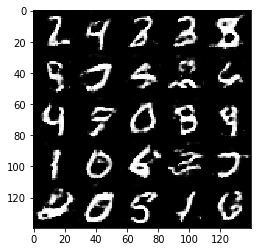

Epoch 2/2... Step 1010... Discriminator Loss: 0.5518... Generator Loss: 1.2228
Epoch 2/2... Step 1020... Discriminator Loss: 0.6491... Generator Loss: 1.6820
Epoch 2/2... Step 1030... Discriminator Loss: 0.8798... Generator Loss: 1.5192
Epoch 2/2... Step 1040... Discriminator Loss: 1.0023... Generator Loss: 0.6481
Epoch 2/2... Step 1050... Discriminator Loss: 0.5418... Generator Loss: 1.6683
Epoch 2/2... Step 1060... Discriminator Loss: 0.6793... Generator Loss: 1.0502
Epoch 2/2... Step 1070... Discriminator Loss: 1.1277... Generator Loss: 0.5957
Epoch 2/2... Step 1080... Discriminator Loss: 1.2141... Generator Loss: 0.5054
Epoch 2/2... Step 1090... Discriminator Loss: 0.9620... Generator Loss: 0.6283
Epoch 2/2... Step 1100... Discriminator Loss: 0.6812... Generator Loss: 1.2556


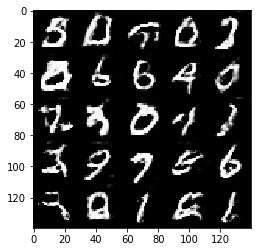

Epoch 2/2... Step 1110... Discriminator Loss: 0.8786... Generator Loss: 0.8151
Epoch 2/2... Step 1120... Discriminator Loss: 2.0052... Generator Loss: 0.2886
Epoch 2/2... Step 1130... Discriminator Loss: 0.7404... Generator Loss: 1.8660
Epoch 2/2... Step 1140... Discriminator Loss: 0.8515... Generator Loss: 1.9666
Epoch 2/2... Step 1150... Discriminator Loss: 0.8289... Generator Loss: 0.9066
Epoch 2/2... Step 1160... Discriminator Loss: 0.7274... Generator Loss: 1.0121
Epoch 2/2... Step 1170... Discriminator Loss: 2.5485... Generator Loss: 0.1256
Epoch 2/2... Step 1180... Discriminator Loss: 0.7275... Generator Loss: 1.0502
Epoch 2/2... Step 1190... Discriminator Loss: 0.7184... Generator Loss: 0.9519
Epoch 2/2... Step 1200... Discriminator Loss: 1.4099... Generator Loss: 0.4506


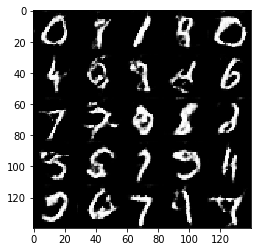

Epoch 2/2... Step 1210... Discriminator Loss: 1.5411... Generator Loss: 0.4055
Epoch 2/2... Step 1220... Discriminator Loss: 1.1075... Generator Loss: 0.6114
Epoch 2/2... Step 1230... Discriminator Loss: 0.4469... Generator Loss: 1.6446
Epoch 2/2... Step 1240... Discriminator Loss: 0.7048... Generator Loss: 0.9921
Epoch 2/2... Step 1250... Discriminator Loss: 0.5296... Generator Loss: 1.3423
Epoch 2/2... Step 1260... Discriminator Loss: 0.5548... Generator Loss: 1.2092
Epoch 2/2... Step 1270... Discriminator Loss: 1.1695... Generator Loss: 2.2000
Epoch 2/2... Step 1280... Discriminator Loss: 0.7188... Generator Loss: 1.0211
Epoch 2/2... Step 1290... Discriminator Loss: 0.5130... Generator Loss: 1.2592
Epoch 2/2... Step 1300... Discriminator Loss: 1.2559... Generator Loss: 0.4514


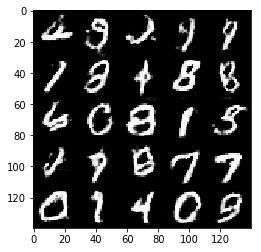

Epoch 2/2... Step 1310... Discriminator Loss: 0.8324... Generator Loss: 1.9406
Epoch 2/2... Step 1320... Discriminator Loss: 0.7244... Generator Loss: 1.6210
Epoch 2/2... Step 1330... Discriminator Loss: 1.1814... Generator Loss: 0.5709
Epoch 2/2... Step 1340... Discriminator Loss: 0.7987... Generator Loss: 0.8281
Epoch 2/2... Step 1350... Discriminator Loss: 0.7996... Generator Loss: 0.8406
Epoch 2/2... Step 1360... Discriminator Loss: 0.8860... Generator Loss: 2.8768
Epoch 2/2... Step 1370... Discriminator Loss: 1.9301... Generator Loss: 0.2509
Epoch 2/2... Step 1380... Discriminator Loss: 0.5325... Generator Loss: 1.3751
Epoch 2/2... Step 1390... Discriminator Loss: 0.3858... Generator Loss: 1.9275
Epoch 2/2... Step 1400... Discriminator Loss: 0.4320... Generator Loss: 1.3982


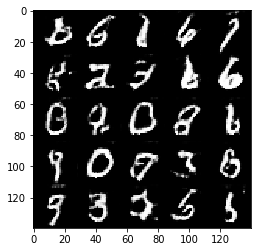

Epoch 2/2... Step 1410... Discriminator Loss: 1.7076... Generator Loss: 4.3769
Epoch 2/2... Step 1420... Discriminator Loss: 0.9119... Generator Loss: 0.7274
Epoch 2/2... Step 1430... Discriminator Loss: 0.4217... Generator Loss: 1.4771
Epoch 2/2... Step 1440... Discriminator Loss: 0.5318... Generator Loss: 2.3837
Epoch 2/2... Step 1450... Discriminator Loss: 0.8078... Generator Loss: 1.8713
Epoch 2/2... Step 1460... Discriminator Loss: 1.0181... Generator Loss: 0.6845
Epoch 2/2... Step 1470... Discriminator Loss: 0.7828... Generator Loss: 1.1710
Epoch 2/2... Step 1480... Discriminator Loss: 0.7874... Generator Loss: 1.0417
Epoch 2/2... Step 1490... Discriminator Loss: 0.5116... Generator Loss: 1.6066
Epoch 2/2... Step 1500... Discriminator Loss: 0.8346... Generator Loss: 0.8272


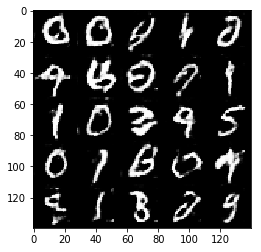

Epoch 2/2... Step 1510... Discriminator Loss: 0.4628... Generator Loss: 1.9384
Epoch 2/2... Step 1520... Discriminator Loss: 0.6890... Generator Loss: 1.0034
Epoch 2/2... Step 1530... Discriminator Loss: 0.5041... Generator Loss: 1.4013
Epoch 2/2... Step 1540... Discriminator Loss: 0.7671... Generator Loss: 0.8913
Epoch 2/2... Step 1550... Discriminator Loss: 0.9430... Generator Loss: 0.7316
Epoch 2/2... Step 1560... Discriminator Loss: 1.1478... Generator Loss: 0.6495
Epoch 2/2... Step 1570... Discriminator Loss: 0.9389... Generator Loss: 0.7846
Epoch 2/2... Step 1580... Discriminator Loss: 1.1253... Generator Loss: 0.5689
Epoch 2/2... Step 1590... Discriminator Loss: 1.0059... Generator Loss: 0.8171
Epoch 2/2... Step 1600... Discriminator Loss: 0.5174... Generator Loss: 1.7679


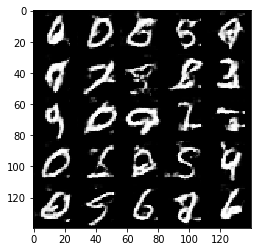

Epoch 2/2... Step 1610... Discriminator Loss: 0.7071... Generator Loss: 1.0172
Epoch 2/2... Step 1620... Discriminator Loss: 0.4102... Generator Loss: 1.5632
Epoch 2/2... Step 1630... Discriminator Loss: 0.3485... Generator Loss: 1.8223
Epoch 2/2... Step 1640... Discriminator Loss: 0.8189... Generator Loss: 0.9481
Epoch 2/2... Step 1650... Discriminator Loss: 1.0677... Generator Loss: 0.7616
Epoch 2/2... Step 1660... Discriminator Loss: 0.4031... Generator Loss: 1.7478
Epoch 2/2... Step 1670... Discriminator Loss: 1.6171... Generator Loss: 0.3694
Epoch 2/2... Step 1680... Discriminator Loss: 1.2182... Generator Loss: 0.6887
Epoch 2/2... Step 1690... Discriminator Loss: 0.6501... Generator Loss: 2.5837
Epoch 2/2... Step 1700... Discriminator Loss: 1.1737... Generator Loss: 0.5834


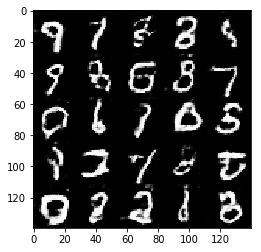

Epoch 2/2... Step 1710... Discriminator Loss: 0.9301... Generator Loss: 2.1840
Epoch 2/2... Step 1720... Discriminator Loss: 0.6896... Generator Loss: 1.1435
Epoch 2/2... Step 1730... Discriminator Loss: 0.4532... Generator Loss: 1.6581
Epoch 2/2... Step 1740... Discriminator Loss: 0.4207... Generator Loss: 1.7011
Epoch 2/2... Step 1750... Discriminator Loss: 0.5028... Generator Loss: 1.2639
Epoch 2/2... Step 1760... Discriminator Loss: 1.0003... Generator Loss: 0.7113
Epoch 2/2... Step 1770... Discriminator Loss: 0.3929... Generator Loss: 1.6586
Epoch 2/2... Step 1780... Discriminator Loss: 0.7483... Generator Loss: 1.0141
Epoch 2/2... Step 1790... Discriminator Loss: 0.7744... Generator Loss: 4.4771
Epoch 2/2... Step 1800... Discriminator Loss: 0.6498... Generator Loss: 2.8091


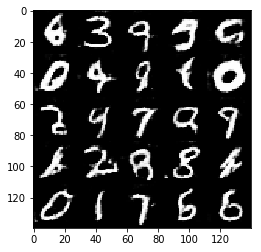

Epoch 2/2... Step 1810... Discriminator Loss: 0.4915... Generator Loss: 1.3751
Epoch 2/2... Step 1820... Discriminator Loss: 1.1552... Generator Loss: 0.7249
Epoch 2/2... Step 1830... Discriminator Loss: 0.6106... Generator Loss: 1.1124
Epoch 2/2... Step 1840... Discriminator Loss: 0.9090... Generator Loss: 0.7587
Epoch 2/2... Step 1850... Discriminator Loss: 1.1651... Generator Loss: 2.2667
Epoch 2/2... Step 1860... Discriminator Loss: 0.7985... Generator Loss: 1.8985
Epoch 2/2... Step 1870... Discriminator Loss: 0.5822... Generator Loss: 1.5818


IndexError: list index out of range

In [102]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10... Discriminator Loss: 1.1777... Generator Loss: 2.3729
Epoch 1/1... Step 20... Discriminator Loss: 0.0649... Generator Loss: 5.7945
Epoch 1/1... Step 30... Discriminator Loss: 0.1255... Generator Loss: 2.8310
Epoch 1/1... Step 40... Discriminator Loss: 0.4573... Generator Loss: 14.0653
Epoch 1/1... Step 50... Discriminator Loss: 0.1741... Generator Loss: 2.7086
Epoch 1/1... Step 60... Discriminator Loss: 1.1933... Generator Loss: 0.5372
Epoch 1/1... Step 70... Discriminator Loss: 0.5731... Generator Loss: 1.4470
Epoch 1/1... Step 80... Discriminator Loss: 0.0257... Generator Loss: 9.6087
Epoch 1/1... Step 90... Discriminator Loss: 0.8667... Generator Loss: 6.4397
Epoch 1/1... Step 100... Discriminator Loss: 0.3070... Generator Loss: 2.2913


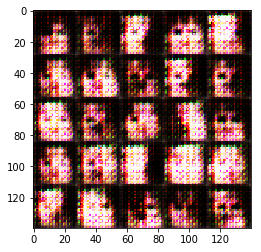

Epoch 1/1... Step 110... Discriminator Loss: 0.2758... Generator Loss: 3.6842
Epoch 1/1... Step 120... Discriminator Loss: 0.1108... Generator Loss: 4.7694
Epoch 1/1... Step 130... Discriminator Loss: 0.9706... Generator Loss: 0.7700
Epoch 1/1... Step 140... Discriminator Loss: 0.1656... Generator Loss: 2.5109
Epoch 1/1... Step 150... Discriminator Loss: 3.9055... Generator Loss: 7.5019
Epoch 1/1... Step 160... Discriminator Loss: 0.5404... Generator Loss: 1.3902
Epoch 1/1... Step 170... Discriminator Loss: 0.2516... Generator Loss: 2.7102
Epoch 1/1... Step 180... Discriminator Loss: 0.2393... Generator Loss: 3.4809
Epoch 1/1... Step 190... Discriminator Loss: 2.3125... Generator Loss: 0.1858
Epoch 1/1... Step 200... Discriminator Loss: 0.4883... Generator Loss: 1.6146


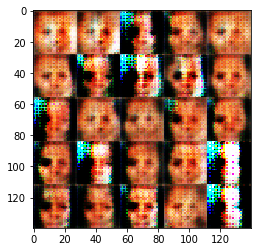

Epoch 1/1... Step 210... Discriminator Loss: 0.7805... Generator Loss: 1.9538
Epoch 1/1... Step 220... Discriminator Loss: 1.1366... Generator Loss: 0.8497
Epoch 1/1... Step 230... Discriminator Loss: 1.0947... Generator Loss: 2.5388
Epoch 1/1... Step 240... Discriminator Loss: 0.3591... Generator Loss: 3.0420
Epoch 1/1... Step 250... Discriminator Loss: 0.7095... Generator Loss: 2.7464
Epoch 1/1... Step 260... Discriminator Loss: 1.0539... Generator Loss: 1.1743
Epoch 1/1... Step 270... Discriminator Loss: 1.0748... Generator Loss: 0.7267
Epoch 1/1... Step 280... Discriminator Loss: 1.6395... Generator Loss: 3.0626
Epoch 1/1... Step 290... Discriminator Loss: 1.2779... Generator Loss: 0.6114
Epoch 1/1... Step 300... Discriminator Loss: 1.7452... Generator Loss: 0.3060


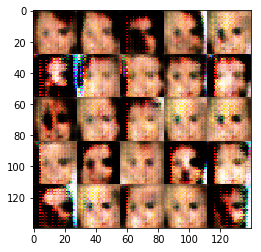

Epoch 1/1... Step 310... Discriminator Loss: 2.3809... Generator Loss: 3.6248
Epoch 1/1... Step 320... Discriminator Loss: 1.2222... Generator Loss: 0.4946
Epoch 1/1... Step 330... Discriminator Loss: 0.9376... Generator Loss: 0.7163
Epoch 1/1... Step 340... Discriminator Loss: 0.7489... Generator Loss: 1.1263
Epoch 1/1... Step 350... Discriminator Loss: 0.8106... Generator Loss: 1.0607
Epoch 1/1... Step 360... Discriminator Loss: 1.1643... Generator Loss: 1.2974
Epoch 1/1... Step 370... Discriminator Loss: 1.0161... Generator Loss: 0.6056
Epoch 1/1... Step 380... Discriminator Loss: 1.5646... Generator Loss: 0.3404
Epoch 1/1... Step 390... Discriminator Loss: 1.2648... Generator Loss: 0.4828
Epoch 1/1... Step 400... Discriminator Loss: 1.0013... Generator Loss: 0.9388


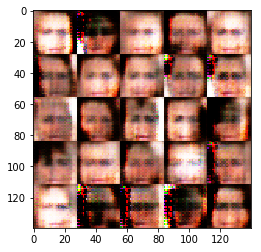

Epoch 1/1... Step 410... Discriminator Loss: 0.9003... Generator Loss: 1.2720
Epoch 1/1... Step 420... Discriminator Loss: 1.1100... Generator Loss: 0.6545
Epoch 1/1... Step 430... Discriminator Loss: 1.3541... Generator Loss: 0.4193
Epoch 1/1... Step 440... Discriminator Loss: 0.9900... Generator Loss: 1.9921
Epoch 1/1... Step 450... Discriminator Loss: 0.9531... Generator Loss: 1.4395
Epoch 1/1... Step 460... Discriminator Loss: 0.8391... Generator Loss: 1.1051
Epoch 1/1... Step 470... Discriminator Loss: 0.9155... Generator Loss: 1.1077
Epoch 1/1... Step 480... Discriminator Loss: 0.9805... Generator Loss: 0.8245
Epoch 1/1... Step 490... Discriminator Loss: 2.2607... Generator Loss: 0.1704
Epoch 1/1... Step 500... Discriminator Loss: 1.3149... Generator Loss: 0.6137


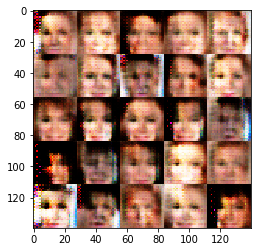

Epoch 1/1... Step 510... Discriminator Loss: 2.5640... Generator Loss: 3.1678
Epoch 1/1... Step 520... Discriminator Loss: 0.7104... Generator Loss: 1.5663
Epoch 1/1... Step 530... Discriminator Loss: 1.4830... Generator Loss: 0.4224
Epoch 1/1... Step 540... Discriminator Loss: 1.4472... Generator Loss: 0.4449
Epoch 1/1... Step 550... Discriminator Loss: 1.3869... Generator Loss: 0.5038
Epoch 1/1... Step 560... Discriminator Loss: 1.3803... Generator Loss: 2.3019
Epoch 1/1... Step 570... Discriminator Loss: 1.1049... Generator Loss: 0.8569
Epoch 1/1... Step 580... Discriminator Loss: 1.2526... Generator Loss: 2.8777
Epoch 1/1... Step 590... Discriminator Loss: 0.9085... Generator Loss: 1.9819
Epoch 1/1... Step 600... Discriminator Loss: 1.7611... Generator Loss: 0.2647


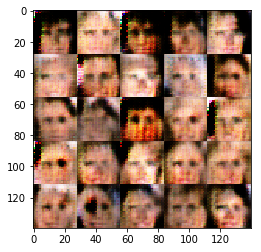

Epoch 1/1... Step 610... Discriminator Loss: 1.1625... Generator Loss: 2.9381
Epoch 1/1... Step 620... Discriminator Loss: 1.4580... Generator Loss: 3.0084
Epoch 1/1... Step 630... Discriminator Loss: 1.3547... Generator Loss: 0.4435
Epoch 1/1... Step 640... Discriminator Loss: 1.5278... Generator Loss: 1.8803
Epoch 1/1... Step 650... Discriminator Loss: 1.0091... Generator Loss: 0.7004
Epoch 1/1... Step 660... Discriminator Loss: 1.2848... Generator Loss: 0.6562
Epoch 1/1... Step 670... Discriminator Loss: 1.6114... Generator Loss: 0.4504
Epoch 1/1... Step 680... Discriminator Loss: 1.2361... Generator Loss: 1.2720
Epoch 1/1... Step 690... Discriminator Loss: 1.2056... Generator Loss: 0.6914
Epoch 1/1... Step 700... Discriminator Loss: 0.8051... Generator Loss: 1.4752


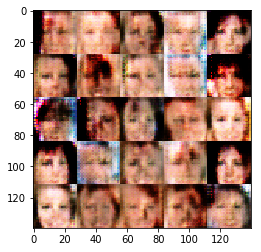

Epoch 1/1... Step 710... Discriminator Loss: 1.1762... Generator Loss: 0.8317
Epoch 1/1... Step 720... Discriminator Loss: 1.2043... Generator Loss: 0.8542
Epoch 1/1... Step 730... Discriminator Loss: 0.7466... Generator Loss: 1.9131
Epoch 1/1... Step 740... Discriminator Loss: 0.9877... Generator Loss: 0.7860
Epoch 1/1... Step 750... Discriminator Loss: 1.7822... Generator Loss: 0.3034
Epoch 1/1... Step 760... Discriminator Loss: 0.8550... Generator Loss: 0.9594
Epoch 1/1... Step 770... Discriminator Loss: 1.0552... Generator Loss: 1.8079
Epoch 1/1... Step 780... Discriminator Loss: 2.0422... Generator Loss: 0.1940
Epoch 1/1... Step 790... Discriminator Loss: 1.0606... Generator Loss: 1.3825
Epoch 1/1... Step 800... Discriminator Loss: 1.7532... Generator Loss: 0.2913


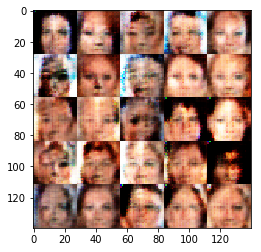

Epoch 1/1... Step 810... Discriminator Loss: 1.0017... Generator Loss: 0.8194
Epoch 1/1... Step 820... Discriminator Loss: 0.8600... Generator Loss: 1.0601
Epoch 1/1... Step 830... Discriminator Loss: 0.8371... Generator Loss: 1.8540
Epoch 1/1... Step 840... Discriminator Loss: 1.0396... Generator Loss: 0.9254
Epoch 1/1... Step 850... Discriminator Loss: 1.5729... Generator Loss: 0.4825
Epoch 1/1... Step 860... Discriminator Loss: 0.8180... Generator Loss: 1.5103
Epoch 1/1... Step 870... Discriminator Loss: 1.0332... Generator Loss: 1.9433
Epoch 1/1... Step 880... Discriminator Loss: 1.0875... Generator Loss: 0.9317
Epoch 1/1... Step 890... Discriminator Loss: 0.8890... Generator Loss: 1.7129
Epoch 1/1... Step 900... Discriminator Loss: 1.3042... Generator Loss: 0.4771


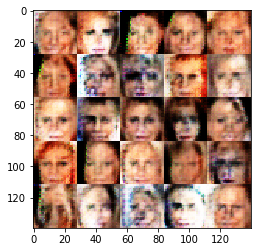

Epoch 1/1... Step 910... Discriminator Loss: 1.1524... Generator Loss: 1.7889
Epoch 1/1... Step 920... Discriminator Loss: 0.8487... Generator Loss: 1.0023
Epoch 1/1... Step 930... Discriminator Loss: 1.4433... Generator Loss: 0.4184
Epoch 1/1... Step 940... Discriminator Loss: 1.7089... Generator Loss: 1.6768
Epoch 1/1... Step 950... Discriminator Loss: 1.1170... Generator Loss: 0.5979
Epoch 1/1... Step 960... Discriminator Loss: 2.1804... Generator Loss: 3.2870
Epoch 1/1... Step 970... Discriminator Loss: 1.0838... Generator Loss: 0.7074
Epoch 1/1... Step 980... Discriminator Loss: 1.0233... Generator Loss: 2.3266
Epoch 1/1... Step 990... Discriminator Loss: 1.0003... Generator Loss: 1.6814
Epoch 1/1... Step 1000... Discriminator Loss: 0.8853... Generator Loss: 1.0594


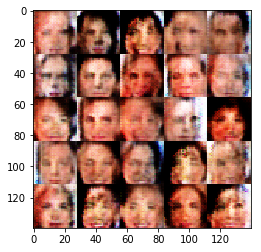

Epoch 1/1... Step 1010... Discriminator Loss: 1.7376... Generator Loss: 0.2838
Epoch 1/1... Step 1020... Discriminator Loss: 1.2751... Generator Loss: 0.6125
Epoch 1/1... Step 1030... Discriminator Loss: 0.8531... Generator Loss: 1.3844
Epoch 1/1... Step 1040... Discriminator Loss: 1.4507... Generator Loss: 0.4156
Epoch 1/1... Step 1050... Discriminator Loss: 1.1322... Generator Loss: 0.5911
Epoch 1/1... Step 1060... Discriminator Loss: 1.2783... Generator Loss: 1.2676
Epoch 1/1... Step 1070... Discriminator Loss: 1.1454... Generator Loss: 0.6778
Epoch 1/1... Step 1080... Discriminator Loss: 1.4025... Generator Loss: 0.4141
Epoch 1/1... Step 1090... Discriminator Loss: 1.0100... Generator Loss: 0.9653
Epoch 1/1... Step 1100... Discriminator Loss: 1.9833... Generator Loss: 0.2156


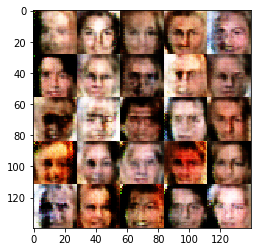

Epoch 1/1... Step 1110... Discriminator Loss: 1.1069... Generator Loss: 0.6876
Epoch 1/1... Step 1120... Discriminator Loss: 0.8928... Generator Loss: 0.9658
Epoch 1/1... Step 1130... Discriminator Loss: 1.2993... Generator Loss: 0.5133
Epoch 1/1... Step 1140... Discriminator Loss: 1.2355... Generator Loss: 0.5100
Epoch 1/1... Step 1150... Discriminator Loss: 1.0215... Generator Loss: 1.5393
Epoch 1/1... Step 1160... Discriminator Loss: 1.1422... Generator Loss: 1.9562
Epoch 1/1... Step 1170... Discriminator Loss: 1.1397... Generator Loss: 0.7899
Epoch 1/1... Step 1180... Discriminator Loss: 1.1046... Generator Loss: 0.6707
Epoch 1/1... Step 1190... Discriminator Loss: 1.5766... Generator Loss: 0.3505
Epoch 1/1... Step 1200... Discriminator Loss: 1.0563... Generator Loss: 1.7117


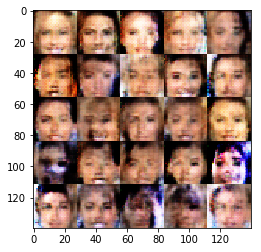

Epoch 1/1... Step 1210... Discriminator Loss: 1.1594... Generator Loss: 0.7077
Epoch 1/1... Step 1220... Discriminator Loss: 1.2837... Generator Loss: 0.4673
Epoch 1/1... Step 1230... Discriminator Loss: 1.5125... Generator Loss: 0.3898
Epoch 1/1... Step 1240... Discriminator Loss: 0.8473... Generator Loss: 1.7946
Epoch 1/1... Step 1250... Discriminator Loss: 0.8004... Generator Loss: 1.0794
Epoch 1/1... Step 1260... Discriminator Loss: 1.3108... Generator Loss: 1.3920
Epoch 1/1... Step 1270... Discriminator Loss: 1.0837... Generator Loss: 0.9736
Epoch 1/1... Step 1280... Discriminator Loss: 0.9215... Generator Loss: 1.0148
Epoch 1/1... Step 1290... Discriminator Loss: 1.3211... Generator Loss: 0.7729
Epoch 1/1... Step 1300... Discriminator Loss: 1.0862... Generator Loss: 0.7143


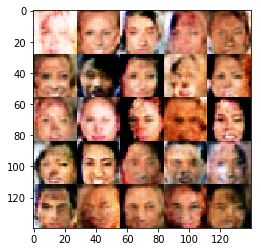

Epoch 1/1... Step 1310... Discriminator Loss: 1.1452... Generator Loss: 0.6518
Epoch 1/1... Step 1320... Discriminator Loss: 1.0607... Generator Loss: 0.8916
Epoch 1/1... Step 1330... Discriminator Loss: 0.9025... Generator Loss: 1.0971
Epoch 1/1... Step 1340... Discriminator Loss: 1.0936... Generator Loss: 0.6268
Epoch 1/1... Step 1350... Discriminator Loss: 1.1390... Generator Loss: 1.2709
Epoch 1/1... Step 1360... Discriminator Loss: 1.1609... Generator Loss: 0.8543
Epoch 1/1... Step 1370... Discriminator Loss: 1.1223... Generator Loss: 0.8635
Epoch 1/1... Step 1380... Discriminator Loss: 1.3380... Generator Loss: 0.4967
Epoch 1/1... Step 1390... Discriminator Loss: 1.4259... Generator Loss: 1.4929
Epoch 1/1... Step 1400... Discriminator Loss: 1.2501... Generator Loss: 0.5710


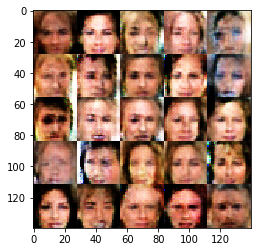

Epoch 1/1... Step 1410... Discriminator Loss: 1.1199... Generator Loss: 0.7094
Epoch 1/1... Step 1420... Discriminator Loss: 1.1286... Generator Loss: 1.0667
Epoch 1/1... Step 1430... Discriminator Loss: 1.1574... Generator Loss: 0.5640
Epoch 1/1... Step 1440... Discriminator Loss: 1.4435... Generator Loss: 0.3902
Epoch 1/1... Step 1450... Discriminator Loss: 1.2309... Generator Loss: 0.5782
Epoch 1/1... Step 1460... Discriminator Loss: 1.3748... Generator Loss: 1.6700
Epoch 1/1... Step 1470... Discriminator Loss: 1.3495... Generator Loss: 1.6116
Epoch 1/1... Step 1480... Discriminator Loss: 1.0703... Generator Loss: 0.6960
Epoch 1/1... Step 1490... Discriminator Loss: 1.0686... Generator Loss: 0.7600
Epoch 1/1... Step 1500... Discriminator Loss: 1.2416... Generator Loss: 0.5525


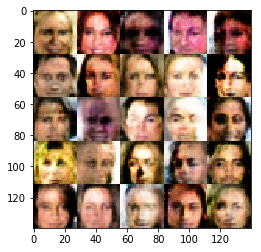

Epoch 1/1... Step 1510... Discriminator Loss: 1.0598... Generator Loss: 0.9595
Epoch 1/1... Step 1520... Discriminator Loss: 1.3026... Generator Loss: 1.0292
Epoch 1/1... Step 1530... Discriminator Loss: 1.2644... Generator Loss: 0.7293
Epoch 1/1... Step 1540... Discriminator Loss: 1.0715... Generator Loss: 0.7590
Epoch 1/1... Step 1550... Discriminator Loss: 1.3651... Generator Loss: 0.4792
Epoch 1/1... Step 1560... Discriminator Loss: 1.0647... Generator Loss: 1.4101
Epoch 1/1... Step 1570... Discriminator Loss: 1.5737... Generator Loss: 1.1102
Epoch 1/1... Step 1580... Discriminator Loss: 1.1348... Generator Loss: 0.9016
Epoch 1/1... Step 1590... Discriminator Loss: 1.1411... Generator Loss: 1.1833
Epoch 1/1... Step 1600... Discriminator Loss: 1.5129... Generator Loss: 1.6340


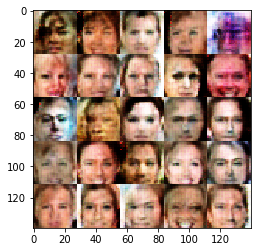

Epoch 1/1... Step 1610... Discriminator Loss: 1.3420... Generator Loss: 0.5458
Epoch 1/1... Step 1620... Discriminator Loss: 1.1276... Generator Loss: 0.8211
Epoch 1/1... Step 1630... Discriminator Loss: 1.0472... Generator Loss: 1.2387
Epoch 1/1... Step 1640... Discriminator Loss: 1.1979... Generator Loss: 1.8986
Epoch 1/1... Step 1650... Discriminator Loss: 1.1574... Generator Loss: 2.1766
Epoch 1/1... Step 1660... Discriminator Loss: 1.0482... Generator Loss: 0.9834
Epoch 1/1... Step 1670... Discriminator Loss: 1.3606... Generator Loss: 0.4579
Epoch 1/1... Step 1680... Discriminator Loss: 1.4067... Generator Loss: 0.4521
Epoch 1/1... Step 1690... Discriminator Loss: 1.1492... Generator Loss: 0.7140
Epoch 1/1... Step 1700... Discriminator Loss: 1.5247... Generator Loss: 0.3698


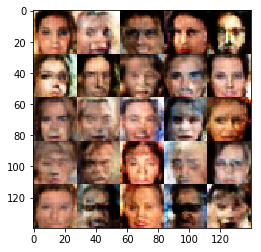

Epoch 1/1... Step 1710... Discriminator Loss: 1.4041... Generator Loss: 0.4049
Epoch 1/1... Step 1720... Discriminator Loss: 1.0634... Generator Loss: 1.4969
Epoch 1/1... Step 1730... Discriminator Loss: 1.4167... Generator Loss: 0.4281
Epoch 1/1... Step 1740... Discriminator Loss: 1.3191... Generator Loss: 0.9744
Epoch 1/1... Step 1750... Discriminator Loss: 1.0910... Generator Loss: 0.9802
Epoch 1/1... Step 1760... Discriminator Loss: 1.0571... Generator Loss: 0.9763
Epoch 1/1... Step 1770... Discriminator Loss: 1.1268... Generator Loss: 0.9443
Epoch 1/1... Step 1780... Discriminator Loss: 1.0300... Generator Loss: 1.0011
Epoch 1/1... Step 1790... Discriminator Loss: 1.0686... Generator Loss: 0.6271
Epoch 1/1... Step 1800... Discriminator Loss: 1.1589... Generator Loss: 0.5939


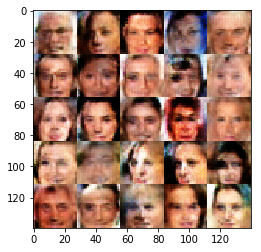

Epoch 1/1... Step 1810... Discriminator Loss: 1.3762... Generator Loss: 1.3134
Epoch 1/1... Step 1820... Discriminator Loss: 1.1058... Generator Loss: 0.9756
Epoch 1/1... Step 1830... Discriminator Loss: 1.5110... Generator Loss: 0.3841
Epoch 1/1... Step 1840... Discriminator Loss: 1.1019... Generator Loss: 0.7158
Epoch 1/1... Step 1850... Discriminator Loss: 1.2257... Generator Loss: 0.6148
Epoch 1/1... Step 1860... Discriminator Loss: 1.1662... Generator Loss: 1.0864
Epoch 1/1... Step 1870... Discriminator Loss: 1.2362... Generator Loss: 0.6886
Epoch 1/1... Step 1880... Discriminator Loss: 1.2919... Generator Loss: 0.7616
Epoch 1/1... Step 1890... Discriminator Loss: 1.0425... Generator Loss: 0.9200
Epoch 1/1... Step 1900... Discriminator Loss: 1.1204... Generator Loss: 1.1611


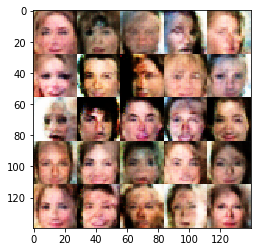

Epoch 1/1... Step 1910... Discriminator Loss: 1.2058... Generator Loss: 0.6036
Epoch 1/1... Step 1920... Discriminator Loss: 1.3138... Generator Loss: 0.5632
Epoch 1/1... Step 1930... Discriminator Loss: 1.2168... Generator Loss: 0.7931
Epoch 1/1... Step 1940... Discriminator Loss: 1.1897... Generator Loss: 0.9428
Epoch 1/1... Step 1950... Discriminator Loss: 1.1200... Generator Loss: 0.9507
Epoch 1/1... Step 1960... Discriminator Loss: 1.3849... Generator Loss: 0.4714
Epoch 1/1... Step 1970... Discriminator Loss: 1.0174... Generator Loss: 1.4984
Epoch 1/1... Step 1980... Discriminator Loss: 1.0493... Generator Loss: 0.8974
Epoch 1/1... Step 1990... Discriminator Loss: 1.1682... Generator Loss: 0.8362
Epoch 1/1... Step 2000... Discriminator Loss: 1.4483... Generator Loss: 0.3887


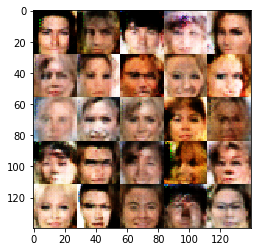

Epoch 1/1... Step 2010... Discriminator Loss: 1.1275... Generator Loss: 0.7212
Epoch 1/1... Step 2020... Discriminator Loss: 1.0978... Generator Loss: 1.0130
Epoch 1/1... Step 2030... Discriminator Loss: 1.1516... Generator Loss: 1.0905
Epoch 1/1... Step 2040... Discriminator Loss: 1.0899... Generator Loss: 0.9876
Epoch 1/1... Step 2050... Discriminator Loss: 1.1101... Generator Loss: 0.8910
Epoch 1/1... Step 2060... Discriminator Loss: 1.1611... Generator Loss: 0.5546
Epoch 1/1... Step 2070... Discriminator Loss: 1.2027... Generator Loss: 0.6915
Epoch 1/1... Step 2080... Discriminator Loss: 1.1325... Generator Loss: 1.2370
Epoch 1/1... Step 2090... Discriminator Loss: 1.0604... Generator Loss: 1.0899
Epoch 1/1... Step 2100... Discriminator Loss: 1.2832... Generator Loss: 0.4981


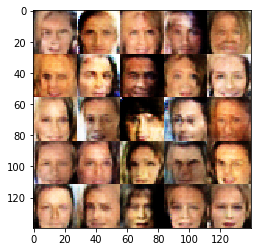

Epoch 1/1... Step 2110... Discriminator Loss: 1.2025... Generator Loss: 1.0291
Epoch 1/1... Step 2120... Discriminator Loss: 1.1453... Generator Loss: 0.6146
Epoch 1/1... Step 2130... Discriminator Loss: 1.4111... Generator Loss: 0.4222
Epoch 1/1... Step 2140... Discriminator Loss: 1.3909... Generator Loss: 0.6767
Epoch 1/1... Step 2150... Discriminator Loss: 1.2805... Generator Loss: 1.8506
Epoch 1/1... Step 2160... Discriminator Loss: 1.3305... Generator Loss: 0.9070
Epoch 1/1... Step 2170... Discriminator Loss: 1.3004... Generator Loss: 0.4729
Epoch 1/1... Step 2180... Discriminator Loss: 1.3032... Generator Loss: 0.5650
Epoch 1/1... Step 2190... Discriminator Loss: 1.1360... Generator Loss: 1.0366
Epoch 1/1... Step 2200... Discriminator Loss: 1.0261... Generator Loss: 0.9618


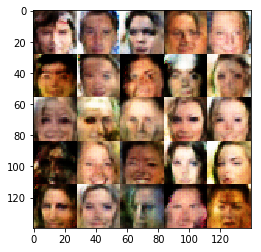

Epoch 1/1... Step 2210... Discriminator Loss: 1.4936... Generator Loss: 0.3661
Epoch 1/1... Step 2220... Discriminator Loss: 1.2640... Generator Loss: 1.2836
Epoch 1/1... Step 2230... Discriminator Loss: 1.3410... Generator Loss: 0.5210
Epoch 1/1... Step 2240... Discriminator Loss: 1.2498... Generator Loss: 0.5316
Epoch 1/1... Step 2250... Discriminator Loss: 1.3366... Generator Loss: 0.4727
Epoch 1/1... Step 2260... Discriminator Loss: 0.9756... Generator Loss: 0.9698
Epoch 1/1... Step 2270... Discriminator Loss: 1.0128... Generator Loss: 1.0879
Epoch 1/1... Step 2280... Discriminator Loss: 1.1930... Generator Loss: 1.2138
Epoch 1/1... Step 2290... Discriminator Loss: 1.0800... Generator Loss: 0.7869
Epoch 1/1... Step 2300... Discriminator Loss: 1.1700... Generator Loss: 0.6583


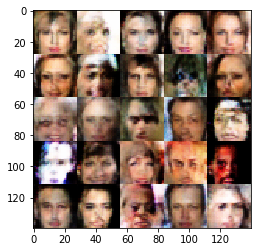

Epoch 1/1... Step 2310... Discriminator Loss: 1.1112... Generator Loss: 1.6058
Epoch 1/1... Step 2320... Discriminator Loss: 1.2164... Generator Loss: 0.6867
Epoch 1/1... Step 2330... Discriminator Loss: 1.3071... Generator Loss: 0.9464
Epoch 1/1... Step 2340... Discriminator Loss: 1.1840... Generator Loss: 0.6549
Epoch 1/1... Step 2350... Discriminator Loss: 1.1501... Generator Loss: 0.6633
Epoch 1/1... Step 2360... Discriminator Loss: 1.1976... Generator Loss: 0.7140
Epoch 1/1... Step 2370... Discriminator Loss: 1.1969... Generator Loss: 0.8874
Epoch 1/1... Step 2380... Discriminator Loss: 1.1987... Generator Loss: 0.7608
Epoch 1/1... Step 2390... Discriminator Loss: 1.6656... Generator Loss: 1.4821
Epoch 1/1... Step 2400... Discriminator Loss: 1.2731... Generator Loss: 1.0446


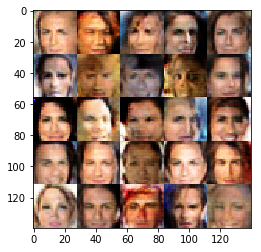

Epoch 1/1... Step 2410... Discriminator Loss: 1.3981... Generator Loss: 0.4034
Epoch 1/1... Step 2420... Discriminator Loss: 1.2646... Generator Loss: 0.5622
Epoch 1/1... Step 2430... Discriminator Loss: 1.2424... Generator Loss: 1.1642
Epoch 1/1... Step 2440... Discriminator Loss: 1.5377... Generator Loss: 0.3997
Epoch 1/1... Step 2450... Discriminator Loss: 1.0606... Generator Loss: 1.5045
Epoch 1/1... Step 2460... Discriminator Loss: 1.0230... Generator Loss: 1.0766
Epoch 1/1... Step 2470... Discriminator Loss: 1.1993... Generator Loss: 1.2067
Epoch 1/1... Step 2480... Discriminator Loss: 1.1992... Generator Loss: 0.7110
Epoch 1/1... Step 2490... Discriminator Loss: 1.4910... Generator Loss: 0.4015
Epoch 1/1... Step 2500... Discriminator Loss: 1.2630... Generator Loss: 0.5392


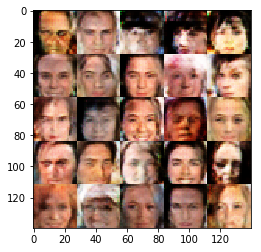

Epoch 1/1... Step 2510... Discriminator Loss: 1.0009... Generator Loss: 1.1301
Epoch 1/1... Step 2520... Discriminator Loss: 1.2356... Generator Loss: 0.5725
Epoch 1/1... Step 2530... Discriminator Loss: 1.3368... Generator Loss: 1.4492
Epoch 1/1... Step 2540... Discriminator Loss: 1.2357... Generator Loss: 0.8341
Epoch 1/1... Step 2550... Discriminator Loss: 1.4990... Generator Loss: 1.3156
Epoch 1/1... Step 2560... Discriminator Loss: 1.2583... Generator Loss: 0.6531
Epoch 1/1... Step 2570... Discriminator Loss: 1.2211... Generator Loss: 1.4794
Epoch 1/1... Step 2580... Discriminator Loss: 1.3151... Generator Loss: 0.5610
Epoch 1/1... Step 2590... Discriminator Loss: 1.2353... Generator Loss: 0.6204
Epoch 1/1... Step 2600... Discriminator Loss: 1.2002... Generator Loss: 0.5984


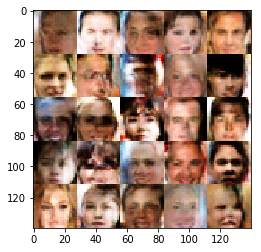

Epoch 1/1... Step 2610... Discriminator Loss: 1.4889... Generator Loss: 2.4063
Epoch 1/1... Step 2620... Discriminator Loss: 1.8134... Generator Loss: 0.2640
Epoch 1/1... Step 2630... Discriminator Loss: 1.1980... Generator Loss: 0.6057
Epoch 1/1... Step 2640... Discriminator Loss: 1.0496... Generator Loss: 1.0281
Epoch 1/1... Step 2650... Discriminator Loss: 1.2406... Generator Loss: 1.0133
Epoch 1/1... Step 2660... Discriminator Loss: 1.0843... Generator Loss: 1.0817
Epoch 1/1... Step 2670... Discriminator Loss: 1.2245... Generator Loss: 0.8214
Epoch 1/1... Step 2680... Discriminator Loss: 1.4710... Generator Loss: 0.4925
Epoch 1/1... Step 2690... Discriminator Loss: 1.9318... Generator Loss: 0.2485
Epoch 1/1... Step 2700... Discriminator Loss: 1.2725... Generator Loss: 0.9412


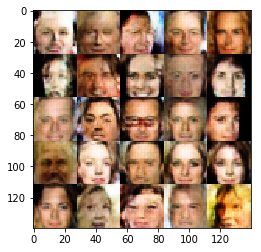

Epoch 1/1... Step 2710... Discriminator Loss: 1.2754... Generator Loss: 0.5312
Epoch 1/1... Step 2720... Discriminator Loss: 1.4820... Generator Loss: 0.3831
Epoch 1/1... Step 2730... Discriminator Loss: 1.1170... Generator Loss: 1.0758
Epoch 1/1... Step 2740... Discriminator Loss: 1.6666... Generator Loss: 0.3233
Epoch 1/1... Step 2750... Discriminator Loss: 1.2231... Generator Loss: 1.3024
Epoch 1/1... Step 2760... Discriminator Loss: 1.1943... Generator Loss: 0.8097
Epoch 1/1... Step 2770... Discriminator Loss: 1.1680... Generator Loss: 0.6053
Epoch 1/1... Step 2780... Discriminator Loss: 1.2528... Generator Loss: 0.5376
Epoch 1/1... Step 2790... Discriminator Loss: 1.3211... Generator Loss: 0.4685
Epoch 1/1... Step 2800... Discriminator Loss: 1.1668... Generator Loss: 0.5849


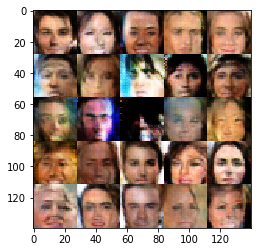

Epoch 1/1... Step 2810... Discriminator Loss: 1.0739... Generator Loss: 0.7513
Epoch 1/1... Step 2820... Discriminator Loss: 1.2369... Generator Loss: 0.7624
Epoch 1/1... Step 2830... Discriminator Loss: 1.2734... Generator Loss: 0.5818
Epoch 1/1... Step 2840... Discriminator Loss: 1.1799... Generator Loss: 0.8936
Epoch 1/1... Step 2850... Discriminator Loss: 1.4193... Generator Loss: 0.4358
Epoch 1/1... Step 2860... Discriminator Loss: 1.1744... Generator Loss: 0.8006
Epoch 1/1... Step 2870... Discriminator Loss: 1.1346... Generator Loss: 0.8095
Epoch 1/1... Step 2880... Discriminator Loss: 1.3813... Generator Loss: 0.4506
Epoch 1/1... Step 2890... Discriminator Loss: 1.2927... Generator Loss: 0.7945
Epoch 1/1... Step 2900... Discriminator Loss: 1.2177... Generator Loss: 0.8063


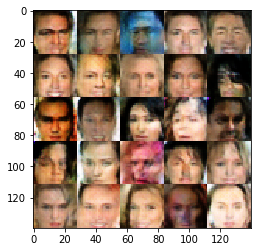

Epoch 1/1... Step 2910... Discriminator Loss: 1.0914... Generator Loss: 1.0704
Epoch 1/1... Step 2920... Discriminator Loss: 1.1569... Generator Loss: 0.9511
Epoch 1/1... Step 2930... Discriminator Loss: 1.2551... Generator Loss: 0.8390
Epoch 1/1... Step 2940... Discriminator Loss: 1.2159... Generator Loss: 1.2653
Epoch 1/1... Step 2950... Discriminator Loss: 1.2478... Generator Loss: 0.5173
Epoch 1/1... Step 2960... Discriminator Loss: 1.1753... Generator Loss: 0.6596
Epoch 1/1... Step 2970... Discriminator Loss: 1.5406... Generator Loss: 0.3620
Epoch 1/1... Step 2980... Discriminator Loss: 1.4700... Generator Loss: 0.3857
Epoch 1/1... Step 2990... Discriminator Loss: 1.1400... Generator Loss: 1.0871
Epoch 1/1... Step 3000... Discriminator Loss: 1.0922... Generator Loss: 0.9626


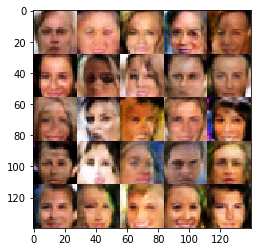

Epoch 1/1... Step 3010... Discriminator Loss: 1.0839... Generator Loss: 1.0501
Epoch 1/1... Step 3020... Discriminator Loss: 1.1088... Generator Loss: 0.8620
Epoch 1/1... Step 3030... Discriminator Loss: 1.3010... Generator Loss: 1.5119
Epoch 1/1... Step 3040... Discriminator Loss: 1.1763... Generator Loss: 0.9758
Epoch 1/1... Step 3050... Discriminator Loss: 1.1072... Generator Loss: 1.0150
Epoch 1/1... Step 3060... Discriminator Loss: 1.1498... Generator Loss: 0.6782
Epoch 1/1... Step 3070... Discriminator Loss: 1.1987... Generator Loss: 0.5729
Epoch 1/1... Step 3080... Discriminator Loss: 1.1342... Generator Loss: 0.5759
Epoch 1/1... Step 3090... Discriminator Loss: 1.8462... Generator Loss: 0.2432
Epoch 1/1... Step 3100... Discriminator Loss: 1.1619... Generator Loss: 0.6391


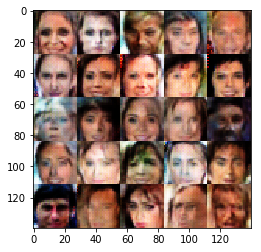

Epoch 1/1... Step 3110... Discriminator Loss: 1.2809... Generator Loss: 0.9346
Epoch 1/1... Step 3120... Discriminator Loss: 1.3934... Generator Loss: 1.7573
Epoch 1/1... Step 3130... Discriminator Loss: 1.0399... Generator Loss: 0.8438
Epoch 1/1... Step 3140... Discriminator Loss: 1.1957... Generator Loss: 0.7917
Epoch 1/1... Step 3150... Discriminator Loss: 1.1727... Generator Loss: 1.4455
Epoch 1/1... Step 3160... Discriminator Loss: 0.9706... Generator Loss: 0.8577


IndexError: list index out of range

In [101]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.